In [1]:
!pip install textblob

In [2]:
!pip install emot

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.5/61.5 kB 2.4 MB/s eta 0:00:00


In [3]:
!pip install emot --upgrade

In [4]:
!pip install emot==2.1 # Install a compatible version of emot

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import collections
import joblib
import nltk
import io
from textblob import Word
import re
import sys, os, csv
import string
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
# import the entire emo_unicode module
#from emot.emo_unicode import EMOJI_UNICODE # Import EMOJI_UNICODE instead of UNICODE_EMOJI
#from emot.emo_unicode import EMOTICONS_EMO # Import EMOTICONS_EMO directly
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from collections import Counter


# Access UNICODE_EMO and EMOTICONS using the module
# UNICODE_EMO = emo_unicode.UNICODE_EMO # No longer needed
# EMOTICONS = emo_unicode.EMOTICONS # No longer needed

  Attempting uninstall: emot
    Found existing installation: emot 3.1
    Uninstalling emot-3.1:
      Successfully uninstalled emot-3.1


## Data Cleaning/Major Preprocessing

In [8]:
def word_prob(word): return dictionary[word] / total
def words(text): return re.findall('[a-z]+', text.lower())
dictionary = Counter(words(open('/content/merged.txt').read()))
max_word_length = max(map(len, dictionary))
total = float(sum(dictionary.values()))

def viterbi_segment(text):
    probs, lasts = [1.0], [0]
    for i in range(1, len(text) + 1):
        prob_k, k = max((probs[j] * word_prob(text[j:i]), j)
                        for j in range(max(0, i - max_word_length), i))
        probs.append(prob_k)
        lasts.append(k)
    words = []
    i = len(text)
    while 0 < i:
        words.append(text[lasts[i]:i])
        i = lasts[i]
    words.reverse()
    return words, probs[-1]

def fix_hashtag(text):
    text = text.group().split(":")[0]
    text = text[1:] # remove '#'
    try:
        test = int(text[0])
        text = text[1:]
    except:
        pass
    output = ' '.join(viterbi_segment(text)[0])
    return output

def prep(tweet):
    """pattern = re.compile(r"(.)\1{2,}")
    tweet = pattern.sub(r"\1\1", str(tweet))
    tweet = re.sub(r'http.?://[^\s]+[\s]?', '', str(tweet))
    punct = string.punctuation
    trantab = str.maketrans(punct, len(punct) * ' ')  # Every punctuation symbol will be replaced by a space
    tweet = tweet.translate(trantab)
    tweet = tweet.lower()
    tweet = tweet.strip()"""

    tweet = tweet.lower()
    tweet = re.sub("(#[A-Za-z0-9]+)", fix_hashtag, tweet)
    tweet = ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())

    tweet = re.sub('\d+', '', str(tweet))
    def get_wordnet_pos(word):
        tag = nltk.pos_tag([word])[0][1][0].upper()
        tag_dict = {"J": wordnet.ADJ, "N": wordnet.NOUN, "V": wordnet.VERB, "R": wordnet.ADV}
        return tag_dict.get(tag, wordnet.NOUN)

    ps = PorterStemmer()
    words = tweet.split()
    lemmatizer = WordNetLemmatizer()
    lemma_words = [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in words]
    tweet = " ".join(lemma_words)

    stopwords_list = stopwords.words('english')
    # Some words which might indicate a certain sentiment are kept via a whitelist
    whitelist = ["n't", "not", "no"]
    words = tweet.split()
    clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1]
    tweet = " ".join(clean_words)

    tweet = tweet.strip()
    return tweet

def vectorise_label(label):
    if label == "empty":return 0
    elif label == "sadness":return 2
    elif label == "enthusiasm":return 1
    elif label == "neutral":return 0
    elif label == "worry":return 2
    elif label == "surprise":return 1
    elif label == "love":return 3
    elif label == "fun":return 1
    elif label == "hate":return 4
    elif label == "happiness":return 1
    elif label == "boredom":return 0
    elif label == "relief":return 1
    elif label == "anger":return 4

In [11]:
import pandas as pd
import csv
import nltk

# Download necessary NLTK data
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

# Define prep function to handle non-string values
def prep(tweet):
    if isinstance(tweet, str):  # Check if the tweet is a string
        return tweet.lower()
    else:
        return ''  # Return an empty string if it's not a valid string

# Read CSV file
data1 = pd.read_csv("/content/sad_processes.csv", sep=',', encoding='utf-8')

# Open output CSV file
with open('/content/sad_prep.csv', 'w', newline='', encoding='utf-8') as file:
    dataWriter = csv.writer(file, delimiter=',', lineterminator="\n")

    # Loop over rows and process data
    for i in range(min(2000, len(data1))):  # Ensure you don't go out of bounds
        tweet = prep(data1.iloc[i, 0])  # Assuming text is in the first column
        dataWriter.writerow([tweet, 2])  # Writing the processed tweet with label 2

    print("Done!")


Done!


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [12]:
count = 0
with open('/content/sad_prep.csv', encoding = "utf8") as csvfile:
    readCSV = csv.reader(csvfile, delimiter=',')
    for row in readCSV:
        count+=1
print(count)

1999


In [14]:
data2 = pd.read_csv('/content/text_emotion.csv', sep=',', encoding='utf-8')
print("Dataset shape:",data2.shape)
print(data2.sentiment[0],":",data2.content[0])

Dataset shape: (40000, 4)
empty : @tiffanylue i know  i was listenin to bad habit earlier and i started freakin at his part =[


In [16]:
count = 0
with open('/content/data_prep.csv') as csvfile:
    readCSV = csv.reader(csvfile, delimiter=',')
    for row in readCSV:
        count+=1
print(count)

40000


## Cleaned data file

In [17]:
data_train = pd.read_csv('/content/emotion_data_prep.csv', sep=',', encoding='utf-8')
print("Dataset shape:",data_train.shape)

Dataset shape: (62014, 2)


<ipython-input-18-36b5d96b1354>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=count.index, y=count.values, alpha=0.8, palette="plasma") # Pass x and y as keyword arguments


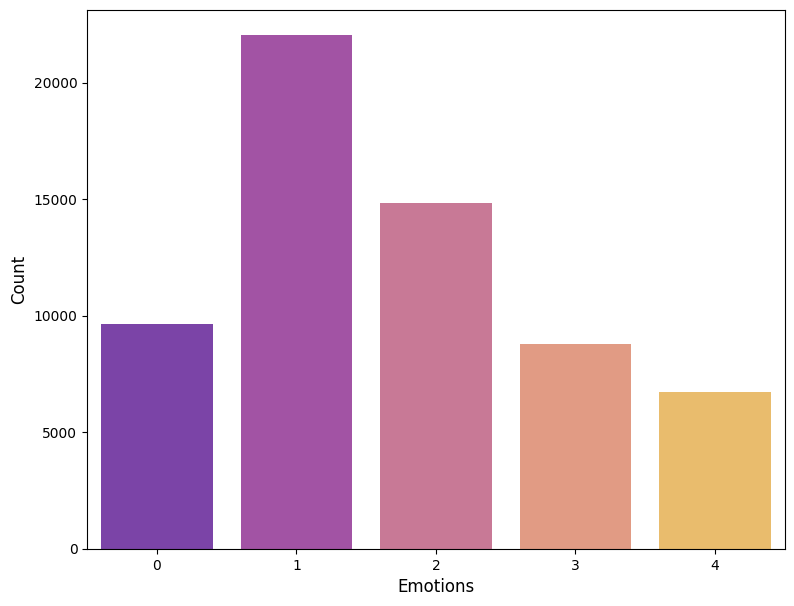

In [18]:
count  = data_train.iloc[:,1].value_counts()
plt.figure(figsize=(9,7))
sns.barplot(x=count.index, y=count.values, alpha=0.8, palette="plasma") # Pass x and y as keyword arguments
plt.ylabel('Count', fontsize=12)
plt.xlabel('Emotions', fontsize=12)
plt.show()
# 0 = neutral
# 1 = happy
# 2 = sad
# 3 = love
# 4 = anger

In [19]:
X_train = data_train.iloc[:,0][:49611]
#[:47583]
y_train = data_train.iloc[:,-1][:49611]
#[:47583]
X_val = data_train.iloc[:,0][49612:]
#[47584:]
y_val = data_train.iloc[:,-1][49612:]
#[47584:]

## Count Vectorization

In [20]:
# Extracting Count Vectors Parameters
count_vect = CountVectorizer(analyzer='word')
count_vect.fit(data_train.iloc[:,0].astype('U'))
X_train_count =  count_vect.transform(X_train.astype('U'))
X_val_count =  count_vect.transform(X_val.astype('U'))
print(count_vect.vocabulary_)

{'ok': 20354, 'sound': 26605, 'goood': 11730, 'hehe': 12827, 'egg': 8756, 'holder': 13183, 'make': 17384, 'ash': 1711, 'wood': 31953, 'shop': 25631, 'link': 16632, 'wooden': 31958, 'tray': 29374, 'anniversary': 1224, 'ea': 8530, 'buy': 4251, 'book': 3485, 'review': 23966, 'help': 12888, 'get': 11375, 'amazon': 1001, 'new': 19587, 'release': 23644, 'sufi': 27500, 'poetry': 22051, 'spiritualism': 26795, 'islam': 14587, 'eeek': 8714, 'come': 5798, 'im': 13877, 'soo': 26519, 'excite': 9543, 'see': 25111, 'thursday': 28765, 'hate': 12604, 'broken': 3902, 'wrist': 32131, 'pe': 21305, 'next': 19621, 'ugh': 29957, 'sb': 24852, 'christmas': 5320, 'surprise': 27730, 'family': 9828, 'ver': 30670, 'merry': 18087, 'justin': 15267, 'josh': 15121, 'sejun': 25150, 'lol': 16834, 'nope': 19924, 'saw': 24836, 'show': 25686, 'tv': 29671, 'claimed': 5454, 'figure': 10157, 'try': 29547, 'non': 19871, 'medium': 17946, 'stats': 27069, 'guy': 12227, 'kunxx': 15953, 'royale': 24382, 'high': 13023, 'halo': 12398

(62014, 32778)


<ipython-input-21-d58bc6479300>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="word", y="freq", data= word_counter_df, ax=ax, palette="plasma")


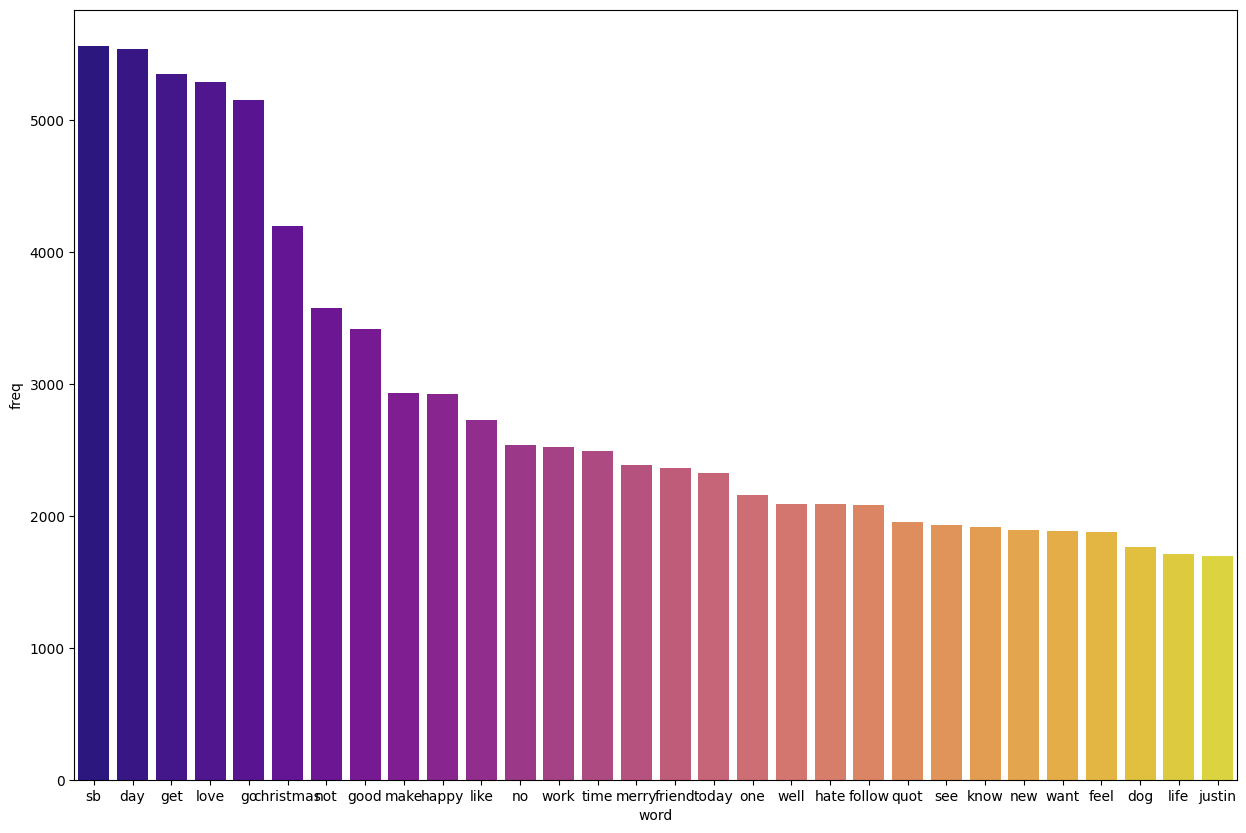

In [21]:
bow = count_vect.fit_transform(data_train.iloc[:,0].astype('U'))
print(bow.shape)
# Replace get_feature_names() with get_feature_names_out()
word_freq = dict(zip(count_vect.get_feature_names_out(), np.asarray(bow.sum(axis=0)).ravel()))
word_counter = collections.Counter(word_freq)
word_counter_df = pd.DataFrame(word_counter.most_common(30), columns = ['word', 'freq'])
fig, ax = plt.subplots(figsize=(15, 10))
sns.barplot(x="word", y="freq", data= word_counter_df, ax=ax, palette="plasma")
plt.show();

# Log Reg Application

In [22]:
logreg1 = LogisticRegression(C=1, max_iter=500)
logreg1.fit(X_train_count, y_train)
y_pred = logreg1.predict(X_val_count)
print('log reg count vectorization accuracy %s' % accuracy_score(y_pred, y_val))

log reg count vectorization accuracy 0.6244154168682471


# Testing Phase

In [23]:
tweets = pd.DataFrame(["For instance, giving a kiss to your younger sibling daily after waking up in the morning and showing him how much you love them. For some happiness means loving life and seeing others happy. While some finds happiness in writing stories. Some conquer happiness in being simple yet the best person they can ever be. Everyone has their own unique way to feel happy by finding things that they never expected to find.", # happy
        "Love is the key to happiness. We all want to lead a happy life. People look around for happiness in power, fashion, wealth, drugs etc. But these things can only give temporary pleasures. The power of love can create miracles. Love can create unity among nations and its citizens. Love is the most beautiful feeling in the world. Love has given different meaning by different people depending upon how they have experienced this wonderful feeling.", # love
        "One day I was studying in my room when, all of a sudden, i heard hot words being exchanged between two persons in the street. I paid no attention, thinking it would be a minor quarrel but soon I heard the voices of a large number of people. I peeped from the window and saw that there was a street quarrel. I went downstairs and reached the spot in the twinkling of an eyes. I was at my wits end on seeing that both of them had come to blows. The people were standing around them and enjoying their quarrel but none tried to pacify them.", # sad
        "I am so angry at you!!!!!", # anger
        "you ve hit a new low with a danger of blm fascist slogan please stop it before too late stop", # anger
        "I love my doggg", # love
        "I think i'm gonna be sick :'‑(", # sad
        "I hate you so much", # anger
        "I'm at work", # neutral
        "@TheTombert i was watching Harpers Island, lol... there was no vodka involved", # neutral
        "sometimes i wish things could go back to the way they were the beginning of last summer", # sad
        "it's your 18th birthday finally!!! yippeeeee", # happy
        "still waiting in line", # neutral
        "oh no he is hospitalised!!!", # sad
        "i want a new laptop", #sad
        "billo bagge billeya daa ki karegi bagge bagge billeya daa ki karegi",
        "Once upon a time in Madagascar there was a small town named Hiroshima ruled by Charles Edgar"
       ])

tweet_count = count_vect.transform(tweets[0])

In [24]:
#Predicting the emotion of the tweet
tweet_pred = logreg1.predict(tweet_count)
print(tweet_pred)
tweets[0]
# 0 = neutral
# 1 = happy
# 2 = sad
# 3 = love
# 4 = anger

[1 3 4 4 4 3 2 4 0 0 2 1 2 2 2 0 2]


0     For instance, giving a kiss to your younger si...
1     Love is the key to happiness. We all want to l...
2     One day I was studying in my room when, all of...
3                             I am so angry at you!!!!!
4     you ve hit a new low with a danger of blm fasc...
5                                       I love my doggg
6                        I think i'm gonna be sick :'‑(
7                                    I hate you so much
8                                           I'm at work
9     @TheTombert i was watching Harpers Island, lol...
10    sometimes i wish things could go back to the w...
11         it's your 18th birthday finally!!! yippeeeee
12                                still waiting in line
13                          oh no he is hospitalised!!!
14                                  i want a new laptop
15    billo bagge billeya daa ki karegi bagge bagge ...
16    Once upon a time in Madagascar there was a sma...
Name: 0, dtype: object

In [25]:
final_result=tweets.copy()

In [26]:
final_result['result']=tweet_pred
final_result=final_result.rename(columns={0:"tweets"})
final_result=final_result.rename(columns={"result":"predicted_emotion"})
final_result=final_result.replace({0: 'Neutral', 1: 'Happy', 2: 'Sad', 3: 'Love', 4: 'Anger'})
final_result

tweets predicted_emotion
0   For instance, giving a kiss to your younger si...             Happy
1   Love is the key to happiness. We all want to l...              Love
2   One day I was studying in my room when, all of...             Anger
3                           I am so angry at you!!!!!             Anger
4   you ve hit a new low with a danger of blm fasc...             Anger
5                                     I love my doggg              Love
6                      I think i'm gonna be sick :'‑(               Sad
7                                  I hate you so much             Anger
8                                         I'm at work           Neutral
9   @TheTombert i was watching Harpers Island, lol...           Neutral
10  sometimes i wish things could go back to the w...               Sad
11       it's your 18th birthday finally!!! yippeeeee             Happy
12                              still waiting in line               Sad
13                        oh no he is hospitalised!!!               Sad
14                                i want a new laptop               Sad
15  billo bagge billeya daa ki karegi bagge bagge ...           Neutral
16  Once upon a time in Madagascar there was a sma...               Sad

In [27]:
import altair as alt

#  count of each predicted emotion
emotion_counts = final_result['predicted_emotion'].value_counts().reset_index()
emotion_counts.columns = ['predicted_emotion', 'count']

#  bar chart using Altair
chart = alt.Chart(emotion_counts).mark_bar().encode(
    x='predicted_emotion',
    y='count'
).properties(
    title='Distribution of Predicted Emotions'
)

chart

alt.Chart(...)

# PIPELINED PROCESS FOR PICKLING

In [28]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [ ]:
pipeline_model = Pipeline([
    ('vectorizer', CountVectorizer(analyzer='word')),
    ('classifier', LogisticRegression(C=1, max_iter=500))
])

In [ ]:
label_mapping = {
    0: 'neutral',
    1: 'happy',
    2: 'sad',
    3: 'love',
    4: 'anger'
}

In [ ]:
pipeline_model.fit(X_train.astype('U'), y_train)

Pipeline(steps=[('vectorizer', CountVectorizer()),
                ('classifier', LogisticRegression(C=1, max_iter=500))])

In [ ]:
y_pred_pipeline = pipeline_model.predict(X_val.astype('U'))
print('Pipeline model accuracy:', accuracy_score(y_pred_pipeline, y_val))

Pipeline model accuracy: 0.6246573133365586


In [ ]:
joblib.dump(pipeline_model, '/content/emotion_pipeline_model.pkl') #no need to use this again unless algos are somehow changed

['/content/emotion_pipeline_model.pkl']

In [ ]:
pipeline_model = joblib.load('/content/drive/MyDrive/Mini_Project_Sem-6/emotion_pipeline_model_old.pkl')

In [29]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [31]:
y_pred = logreg1.predict(X_val_count)

In [32]:
cm = confusion_matrix(y_val, y_pred, labels=[0, 1, 2, 3, 4])


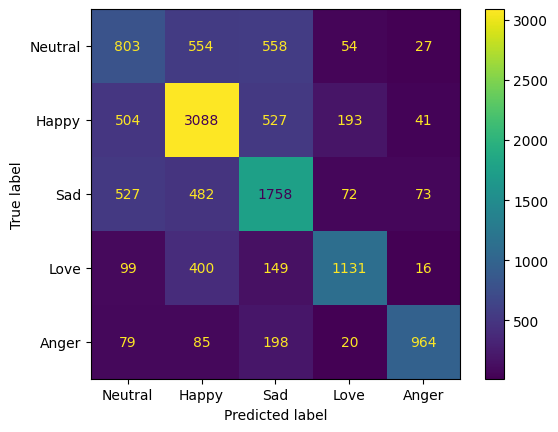

In [33]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Neutral', 'Happy', 'Sad', 'Love', 'Anger'])
disp.plot()
plt.show()

In [35]:
data_train.head(10).sample(5)

lovely  3
2  buy book review help get amazon new release su...  4
6  lol nope saw show tv claimed figure try get no...  0
3               eeek come im soo excite see thursday  1
0                                ok sound goood hehe  3
1  egg holder make ash wood shop link egg holder ...  3